## Short demo notebook for reading data cubes from Object Storage

Importing necessary libraries

In [1]:
import os
import pandas as pd
import shapely
import s3fs
import time
import zarr
import xarray as xr
import xcube
from xcube.api import ts, clip_dataset_by_geometry

Defining Configuration for accessing the data cubes stored in object storage in the cloud. 

In [2]:
def get_obs_configuration():
    s3_client_kwargs = {}

    s3_client_kwargs['endpoint_url'] = 'http://obs.eu-de.otc.t-systems.com'

    s3_client_kwargs['region_name'] = 'eu-de'
    return s3fs.S3FileSystem(anon=True, client_kwargs=s3_client_kwargs)

In [3]:
def open_cube_from_obs(cube_path, obs_file_system):
    store = s3fs.S3Map(root=cube_path, s3=obs_file_system, check=False)
    cached_store = zarr.LRUStoreCache(store, max_size=2 ** 28)
    # with measure_time(tag=f"opened remote dataset {path}"):
    return xr.open_zarr(cached_store)

In [4]:
obs_file_system = get_obs_configuration()

Path to DCS4COP bucket

In [5]:
path = 'dcs4cop-obs-01/'

List all cubes in bucket:

In [6]:
obs_file_system.ls(path)

['dcs4cop-obs-01/MSI_L2_VITO_Chla_SPM_31UET_v041-optimized.zarr',
 'dcs4cop-obs-01/cmems_SPM_DemoCase_v040-optimized.zarr',
 'dcs4cop-obs-01/cmems_SST_DemoCase_v041-optimized.zarr',
 'dcs4cop-obs-01/dcs4cop-bc-olci-sns-l2c-v1-2017-optimized.zarr',
 'dcs4cop-obs-01/dcs4cop-bc-olci-sns-l2c-v1_1.zarr',
 'dcs4cop-obs-01/dcs4cop-bc-sst-sns-l2c-v1-2017-optimized.zarr',
 'dcs4cop-obs-01/dcs4cop-obs-01-log',
 'dcs4cop-obs-01/dcs4cop_xcube_S2A_FLANDERS_2017_1x428x684-optimized.zarr',
 'dcs4cop-obs-01/olci_C2RCCalt_DemoCase_v041-optimized.zarr',
 'dcs4cop-obs-01/seviri_DemoCase_v040-optimized.zarr']

The following code snippet is used for creating an overview table with cube names and how many variables and which variables they contain. Furthermore the first and the last date of the time stamps are printed.

In [9]:
path = 'dcs4cop-obs-01/'


def show_all_datacubes():
    cube_names = []
    df = pd.DataFrame(columns=['cube_name', 'var_nums', 'variables', 'start_date', 'end_date'])
    total_size = 0
    obs_file_system = get_obs_configuration()
    for filepath in sorted(obs_file_system.ls(path)):
        if filepath.endswith('.zarr'):
            ds = open_cube_from_obs(filepath, obs_file_system)
            var_list = []
            for v in ds.variables:
                if v not in ds.dims and 'bnds' not in v: 
                    var_list.append(v)
            cube_names.append(filepath)
            filename = filepath.split('/')[1]
            chunking = ds[var_list[0]].shape
            sd= pd.to_datetime(str(ds.time.values[0])) 
            start_date = sd.strftime('%Y-%m-%d')
            ed= pd.to_datetime(str(ds.time.values[-1])) 
            end_date = ed.strftime('%Y-%m-%d')
            df = df.append({'cube_name': filename, 'var_nums':len(var_list), 'variables':(str(var_list)).replace('[','').replace(']','').replace("'",""), 
                            'start_date':start_date, 'end_date':end_date}, ignore_index=True)
    return df


Get an overview of all cubes in the obs with their variables

In [10]:
overview_cubes = show_all_datacubes()

In [11]:
overview_cubes.style.set_properties(subset=['variables'], **{'width': '300px'})

,cube_name,var_nums,variables,start_date,end_date
0,MSI_L2_VITO_Chla_SPM_31UET_v041-optimized.zarr,2,"Chla, SPM_665",2017-01-16,2017-12-30
1,cmems_SPM_DemoCase_v040-optimized.zarr,1,SPM-OC5_mean,2017-01-02,2017-12-31
2,cmems_SST_DemoCase_v041-optimized.zarr,2,"SST_error, SST_mean_Celcius",2017-01-01,2017-12-31
3,dcs4cop-bc-olci-sns-l2c-v1-2017-optimized.zarr,2,"chl_c2rcc, tsm_c2rcc",2017-01-01,2017-12-31
4,dcs4cop-bc-olci-sns-l2c-v1_1.zarr,3,"chl_c2rcc, tsm_c2rcc, tur_nechad_665",2017-05-01,2017-08-31
5,dcs4cop-bc-sst-sns-l2c-v1-2017-optimized.zarr,1,analysed_sst,2017-01-01,2017-12-31
6,dcs4cop_xcube_S2A_FLANDERS_2017_1x428x684-optimized.zarr,2,"CHL_Bourg, rrs_560",2017-01-02,2017-12-28
7,olci_C2RCCalt_DemoCase_v041-optimized.zarr,2,"Chla_EUNOSAT, SPM_Multi_Band",2017-01-01,2017-12-31
8,seviri_DemoCase_v040-optimized.zarr,1,SPM,2017-01-01,2017-12-31


Inspect one of the cubes:

In [12]:
cube = open_cube_from_obs(os.path.join(path, 'MSI_L2_VITO_Chla_SPM_31UET_v041-optimized.zarr'), get_obs_configuration())

View the metadata of the cube:

In [13]:
cube

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 512, lon: 512, time: 107)
Coordinates:
  * lat       (lat) float64 54.5 54.49 54.48 54.47 ... 50.53 50.52 50.51 50.5
    lat_bnds  (lat, bnds) float64 dask.array<shape=(512, 2), chunksize=(512, 2)>
  * lon       (lon) float64 0.5039 0.5117 0.5195 0.5273 ... 4.48 4.488 4.496
    lon_bnds  (lon, bnds) float64 dask.array<shape=(512, 2), chunksize=(512, 2)>
  * time      (time) datetime64[ns] 2017-01-16T10:53:55.460999936 ... 2017-12-30T11:04:39.456000
Dimensions without coordinates: bnds
Data variables:
    Chla      (time, lat, lon) float32 dask.array<shape=(107, 512, 512), chunksize=(1, 256, 256)>
    SPM_665   (time, lat, lon) float32 dask.array<shape=(107, 512, 512), chunksize=(1, 256, 256)>

Print out the time stamps avaialbe in the cube:

In [14]:
# cube.time.values

Print out the number of time stamps

In [15]:
cube.time.shape

(107,)

View the metadata of a cubes variable:

In [16]:
cube.Chla

<xarray.DataArray 'Chla' (time: 107, lat: 512, lon: 512)>
dask.array<shape=(107, 512, 512), dtype=float32, chunksize=(1, 256, 256)>
Coordinates:
  * lat      (lat) float64 54.5 54.49 54.48 54.47 ... 50.53 50.52 50.51 50.5
  * lon      (lon) float64 0.5039 0.5117 0.5195 0.5273 ... 4.48 4.488 4.496
  * time     (time) datetime64[ns] 2017-01-16T10:53:55.460999936 ... 2017-12-30T11:04:39.456000
Attributes:
    algorithm:           
    ds_flag:             Analysis Ready Data. D6.1 - Product Specification Do...
    grid_mapping:        transverse_mercator
    long_name:           Chla S2
    reference:           RBINS v041 - D6.6 - Multi-Sensor Algorithm Improveme...
    spatial_resampling:  Nearest
    standard_name:       mass_concentration_of_chlorophyll_a_in_sea_water
    units:               mg m-3

In [17]:
cube.Chla.data

dask.array<zarr, shape=(107, 512, 512), dtype=float32, chunksize=(1, 256, 256)>

Plot a cubes variable for a specific time stamp.

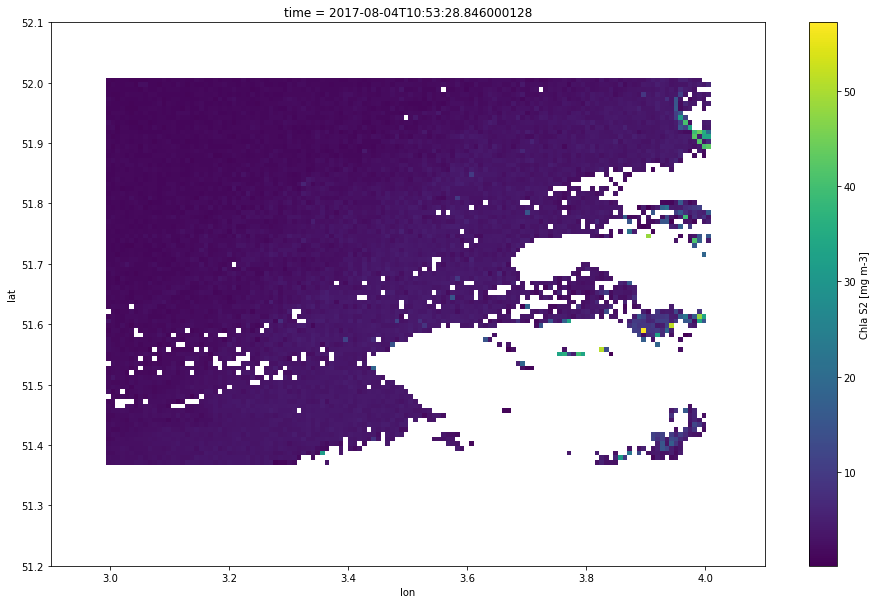

In [18]:
cube.Chla.isel(time=47).plot.imshow(figsize=(16,10), xlim = (2.9, 4.1), ylim = (51.2,52.1))

Plot an image for each time stamp of the data cube:

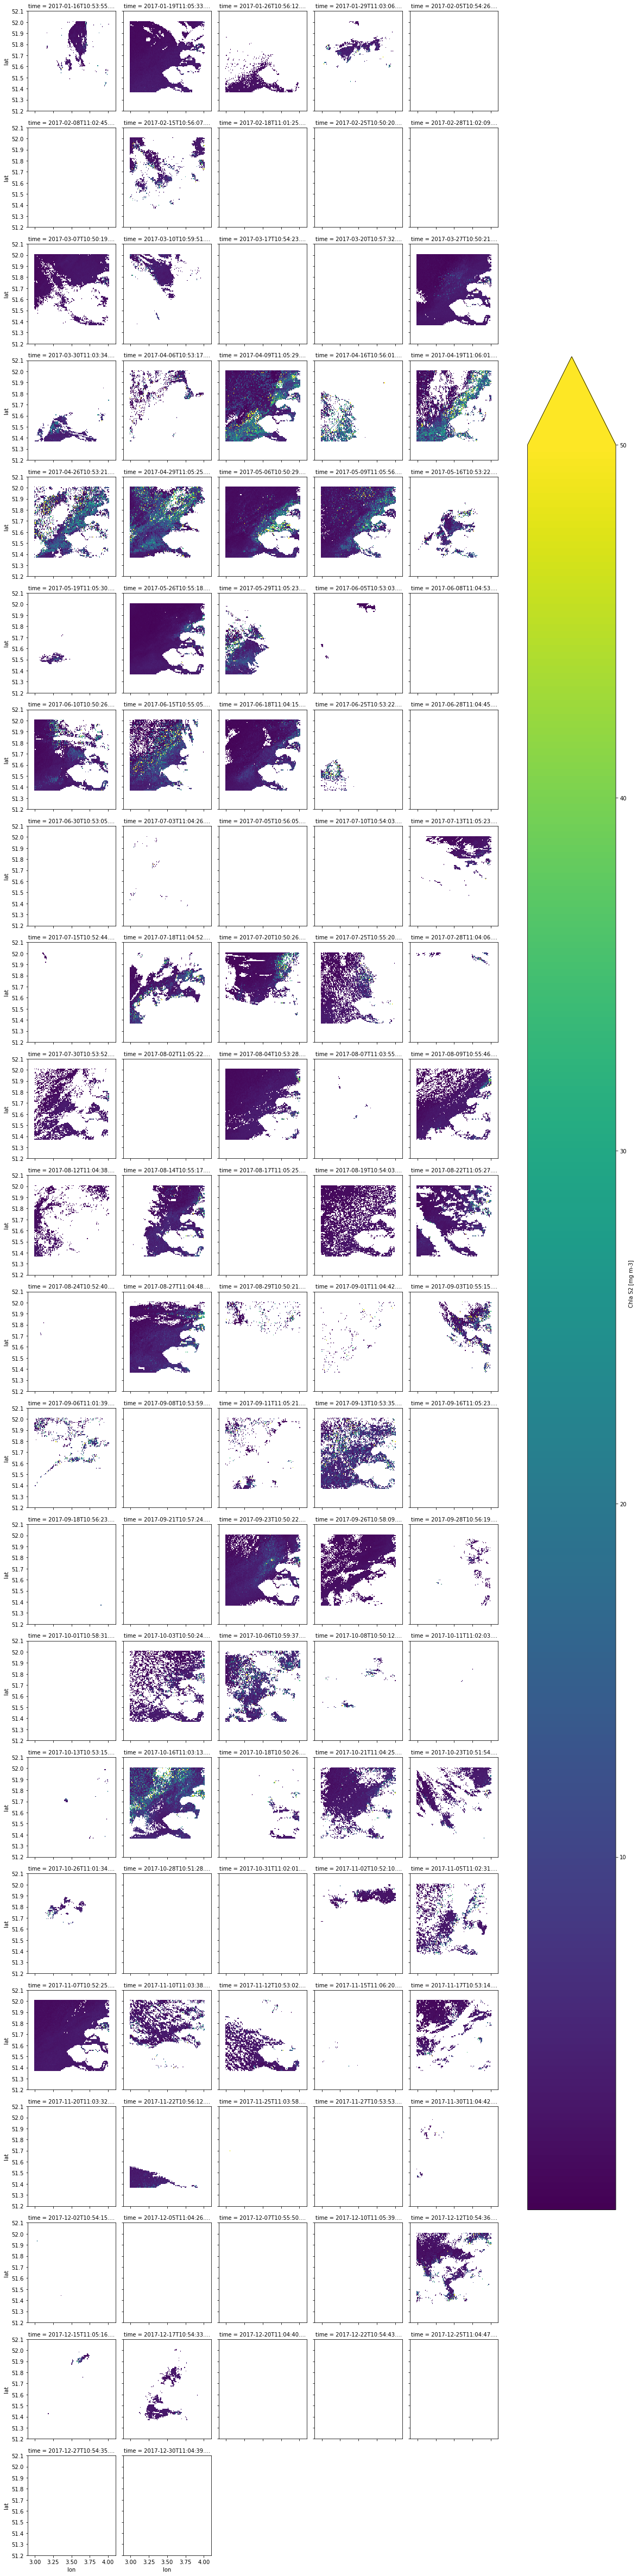

In [19]:
cube.Chla.plot.imshow(col='time', col_wrap=5, xlim = (2.9, 4.1), ylim = (51.2,52.1), vmax=50, cmap='viridis')

View the metadata for another cubes variable.

In [20]:
cube.SPM_665

<xarray.DataArray 'SPM_665' (time: 107, lat: 512, lon: 512)>
dask.array<shape=(107, 512, 512), dtype=float32, chunksize=(1, 256, 256)>
Coordinates:
  * lat      (lat) float64 54.5 54.49 54.48 54.47 ... 50.53 50.52 50.51 50.5
  * lon      (lon) float64 0.5039 0.5117 0.5195 0.5273 ... 4.48 4.488 4.496
  * time     (time) datetime64[ns] 2017-01-16T10:53:55.460999936 ... 2017-12-30T11:04:39.456000
Attributes:
    algorithm:           D6.1 - Product Specification Document
    ds_flag:             Analysis Ready Data. D6.1 - Product Specification Do...
    grid_mapping:        transverse_mercator
    long_name:           SPM 665nm
    reference:           Nechad et al. (2010) recalibrated 2016 - ACOLITE ver...
    spatial_resampling:  Nearest
    standard_name:       mass_concentration_of_suspended_matter_in_sea_water
    units:               g m-3

Plot a cubes variable for a specific time stamp.

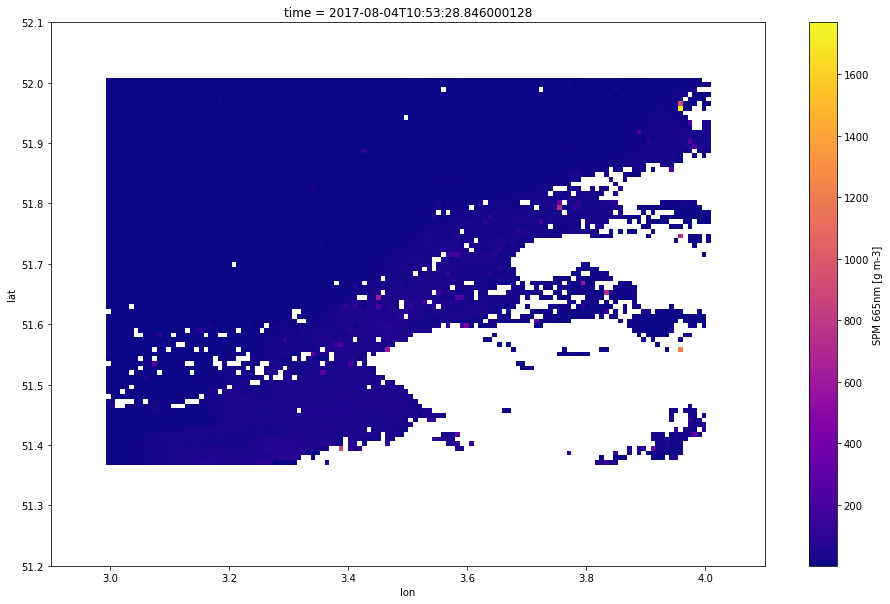

In [21]:
cube.SPM_665.isel(time=47).plot.imshow(figsize=(16,10), xlim = (2.9, 4.1), ylim = (51.2,52.1), cmap='plasma')

Plot an image for each time stamp of the data cube:

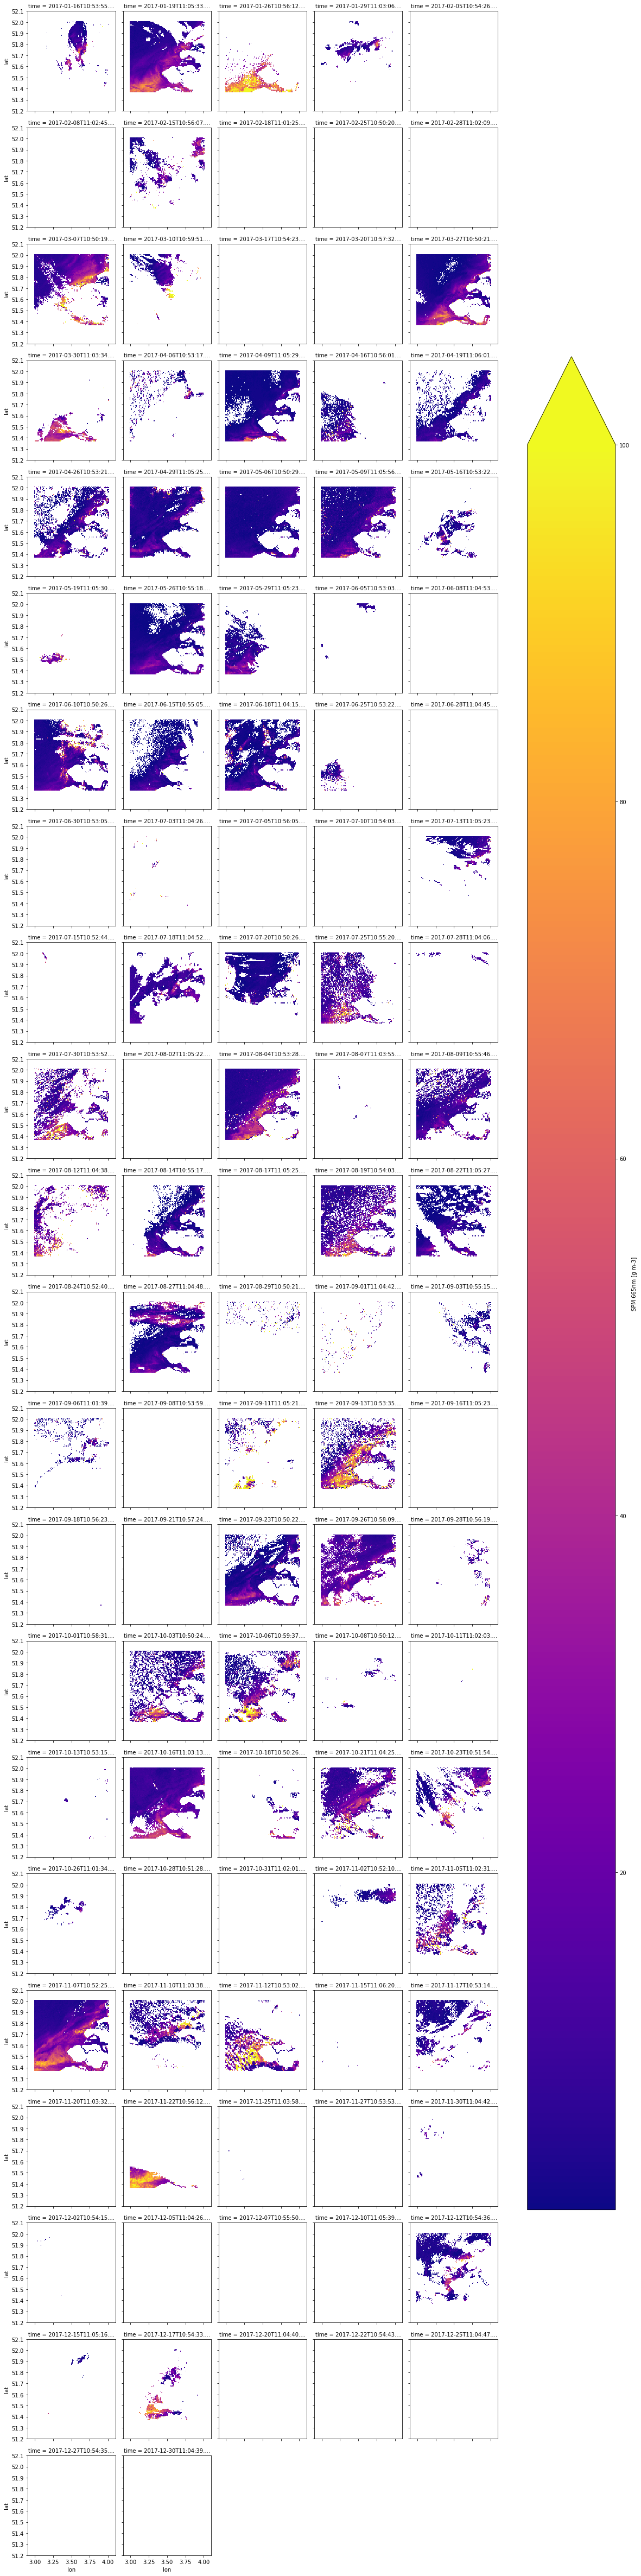

In [22]:
cube.SPM_665.plot.imshow(col='time', col_wrap=5, xlim = (2.9, 4.1), ylim = (51.2,52.1), vmax=100, cmap='plasma')

###  Using xcube.api on cubes

Get a time series for a specific location. Here for lat = 51.65 and lon = 3.6

In [23]:
time_series = ts.get_time_series(cube,[3.6,51.65])

Plot the time series for chlorophyll-a

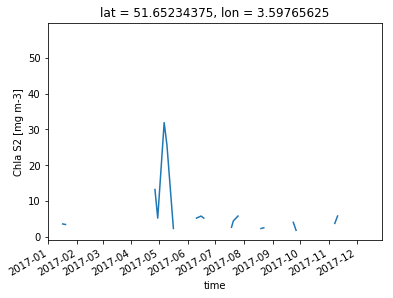

In [24]:
time_series.Chla.plot()

Define an area to make a subset of a cube.

In [25]:
x1 = 3.4  # degree
y1 = 51.6  # degree
x2 = 3.8  # degree
y2 = 51.8  # degree

bbox = x1, y1, x2, y2

Convert bounding box into a shapely object.

In [26]:
bbox = shapely.geometry.box(*bbox)

Clip cube by using the bounding box. 

In [27]:
smaller_cube = clip_dataset_by_geometry(cube,bbox)

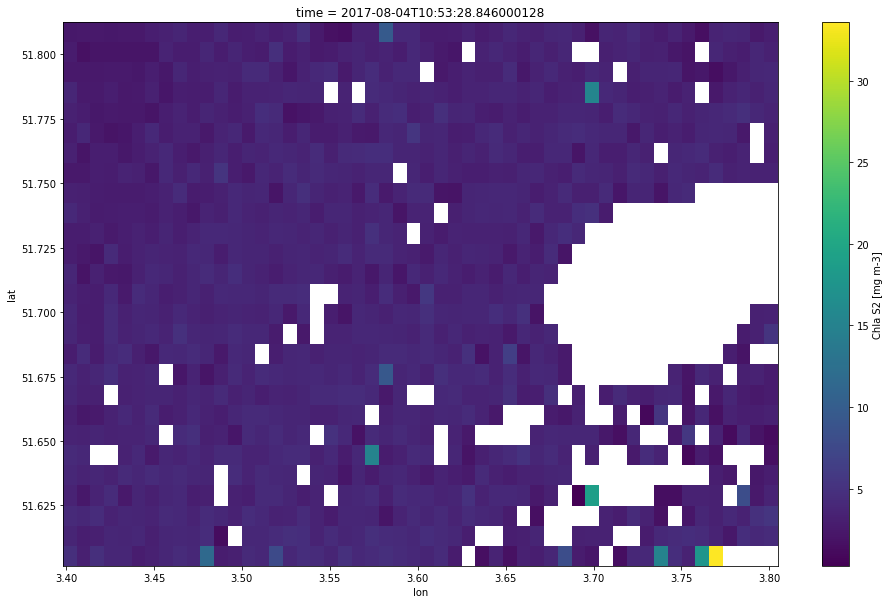

In [28]:
smaller_cube.Chla.isel(time=47).plot.imshow(figsize=(16,10))